In [ ]:
# Read metrics from MLflow
import mlflow

run_ids = ['b05ff27ac9cd434c8422b3aaeb6a2bcd']
metric_keys = ['eval_accuracy', 'eval_loss', 'eval_macro_f1', 'grad_norm', 'loss']
result = []

for metric_key in metric_keys:
  for run_id in run_ids:
    run = mlflow.get_run(run_id)
    history = mlflow.MlflowClient().get_metric_history(run_id, metric_key)
    run_name = run.info.run_name
    for metric in history:
      result.append(
        {
          "run_name": run_name,
          "run_id": run_id,
          "metric_key": metric_key,
          "timestamp": metric.timestamp,
          "step": metric.step,
          "value": metric.value,
        }
      )

current_metric = ""
for r in result:
    if r['metric_key'] != current_metric:
        current_metric = r['metric_key']
        print(f"--- {current_metric} ---")
    print(f"{r['step']}, {r['value']:6f}")


--- eval_accuracy ---
6136, 0.743046
12272, 0.760571
18408, 0.766684
24544, 0.774733
30680, 0.778299
36816, 0.770555
42952, 0.780540
--- eval_loss ---
6136, 0.260152
12272, 0.245664
18408, 0.244887
24544, 0.224374
30680, 0.253584
36816, 0.266983
42952, 0.292273
--- eval_macro_f1 ---
6136, 0.743256
12272, 0.759984
18408, 0.766045
24544, 0.771435
30680, 0.775569
36816, 0.771784
42952, 0.780207
--- grad_norm ---
1022, 3.750586
2044, 3.092508
3066, 2.849662
4088, 3.544153
5110, 2.962558
6132, 3.059551
7154, 2.481273
8176, 2.425777
9198, 3.024428
10220, 2.784454
11242, 2.401860
12264, 3.541090
13286, 3.110585
14308, 2.511896
15330, 3.875180
16352, 5.307340
17374, 3.460467
18396, 3.124600
19418, 3.123239
20440, 3.391132
21462, 2.064321
22484, 4.573524
23506, 1.712668
24528, 2.758032
25550, 8.756660
26572, 3.941511
27594, 4.906476
28616, 1.284494
29638, 2.323006
30660, 3.878440
31682, 1.655721
32704, 4.591517
33726, 1.936713
34748, 2.168209
35770, 5.522344
36792, 3.317699
37814, 3.038477
3883

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tokenizing: 100%|██████████| 9815/9815 [00:00<00:00, 66777.88 examples/s]


Max length of tokenized dataset: 445


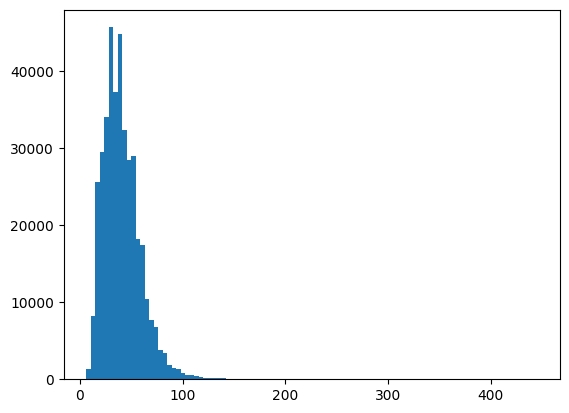

Percentage of samples longer than 64 tokens: 9.73%
Percentage of samples longer than 128 tokens: 0.31%
Percentage of samples longer than 256 tokens: 0.02%
Percentage of samples longer than 512 tokens: 0.00%


In [6]:
# Find max length of tokenized dataset.

import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding
)
from model_fine_tune import build_contextual_dataset, preprocess_function


params = {
    "model_name": "distilbert-base-uncased",
    "max_length": 512,
}

dataset = load_dataset("nyu-mll/glue", "mnli")
dataset = datasets.DatasetDict({
    "train": dataset["train"],
    "validation": dataset["validation_matched"]
})
dataset = build_contextual_dataset(dataset)
train_labels = [int(sample["label"]) for sample in dataset['train']]
unique_labels = sorted(list(set(train_labels)))

# Setup model
model = AutoModelForSequenceClassification.from_pretrained(
    params["model_name"],
    num_labels=len(unique_labels),
    problem_type="single_label_classification"
)

# Setup tokenizer and data collator
tokenizer = AutoTokenizer.from_pretrained(params["model_name"])
special_tokens_dict = {"additional_special_tokens": ["[PREMISE]", "[HYPOTHESIS]"]}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Tokenize dataset
tokenized_datasets = dataset.map(
    lambda x: preprocess_function(
        x, tokenizer, "label", text_field="text_concat", max_length=params["max_length"]
    ),
    batched=True,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing"
)

# Find max length of tokenized dataset
lengths = [len(tokenized_datasets["train"][i]["input_ids"]) for i in range(len(tokenized_datasets["train"]))]

print(f"Max length of tokenized dataset: {max(lengths)}")

# Show the chart with the length of the tokenized dataset
plt.hist(lengths, bins=100)
plt.show()

# show what percentage of the dataset is longer than 64, 128, 256, 512 tokens
for threshold in [64, 128, 256, 512]:
    pct = sum(l > threshold for l in lengths) / len(lengths) * 100
    print(f"Percentage of samples longer than {threshold} tokens: {pct:.2f}%")

In [11]:
import datasets
from datasets import load_dataset
import json
import random

NUM_EXAMPLES = 1000
random.seed(42)

dataset = load_dataset("nyu-mll/glue", "mnli")
examples = dataset["test_matched"]

# Get random indices
indices = random.sample(range(len(examples)), NUM_EXAMPLES)

# Write selected examples to jsonl file
with open("examples.jsonl", "w") as f:
    for idx in indices:
        example = {
            "premise": examples[idx]["premise"],
            "hypothesis": examples[idx]["hypothesis"]
        }
        f.write(json.dumps(example) + "\n")


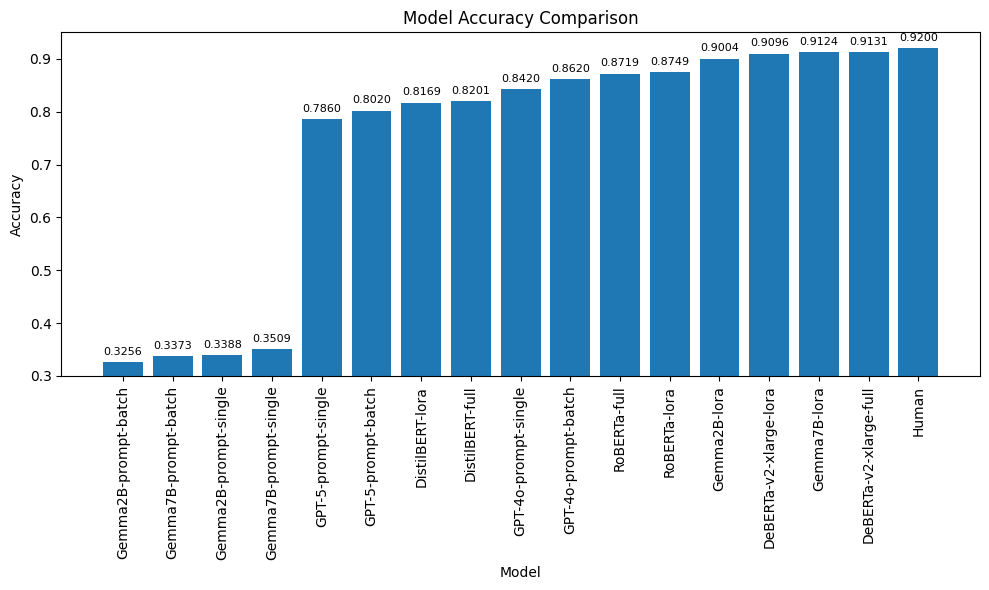

In [28]:
import matplotlib.pyplot as plt



# Model names and their accuracies
model_data = {
    "DistilBERT-lora": 0.8169,
    "DistilBERT-full": 0.8201,
    "RoBERTa-lora": 0.8749,
    "RoBERTa-full": 0.8719,
    "DeBERTa-v2-xlarge-lora": 0.9096,
    "DeBERTa-v2-xlarge-full": 0.9131,
    "Gemma2B-lora": 0.9004,
    "Gemma7B-lora": 0.9124,
    "Gemma2B-prompt-single": 0.3388,
    "Gemma2B-prompt-batch": 0.3256,
    "Gemma7B-prompt-single": 0.3509,
    "Gemma7B-prompt-batch": 0.3373,
    "GPT-4o-prompt-single": 0.8420,
    "GPT-4o-prompt-batch": 0.8620,
    "GPT-5-prompt-single": 0.7860,
    "GPT-5-prompt-batch": 0.8020,
    "Human": 0.9200,
}

# Sort by accuracy
sorted_models = dict(sorted(model_data.items(), key=lambda x: x[1]))

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_models.keys(), sorted_models.values())

# Set y-axis to start from minimum value + 0.05
min_accuracy = min(model_data.values())
plt.ylim(0.3, 0.95)

# Add value labels on bars
for bar, value in zip(bars, sorted_models.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [30]:
(model_data["RoBERTa-lora"] - model_data["RoBERTa-full"]) * 100

0.30000000000000027

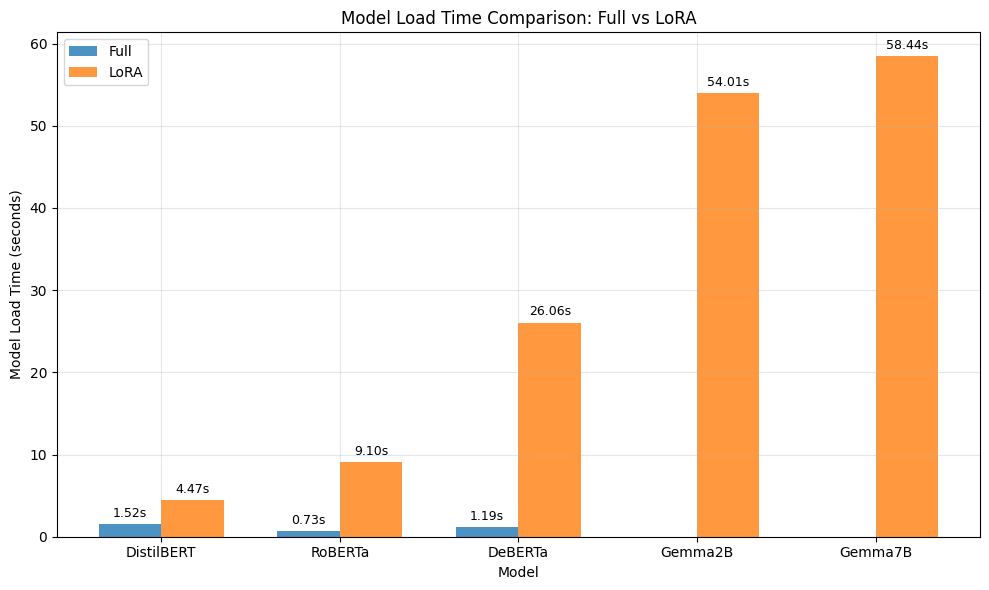

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load costs data
with open('costs.json', 'r') as f:
    costs_data = json.load(f)

# Extract model load times for full and lora models
models = ['DistilBERT', 'RoBERTa', 'DeBERTa', "Gemma2B", "Gemma7B"]
full_times = []
lora_times = []

for model in models:
    full_key = f"{model}-full"
    lora_key = f"{model}-lora"
    
    if full_key in costs_data:
        full_times.append(float(costs_data[full_key]["inference"]["model_load_time"]))
    else:
        full_times.append(0)
    
    if lora_key in costs_data:
        lora_times.append(float(costs_data[lora_key]["inference"]["model_load_time"]))
    else:
        lora_times.append(0)

# Create grouped bar plot
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, full_times, width, label='Full', alpha=0.8)
bars2 = ax.bar(x + width/2, lora_times, width, label='LoRA', alpha=0.8)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    if height > 0:  # Only show label if there's a bar
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}s', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.2f}s', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model')
ax.set_ylabel('Model Load Time (seconds)')
ax.set_title('Model Load Time Comparison: Full vs LoRA')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


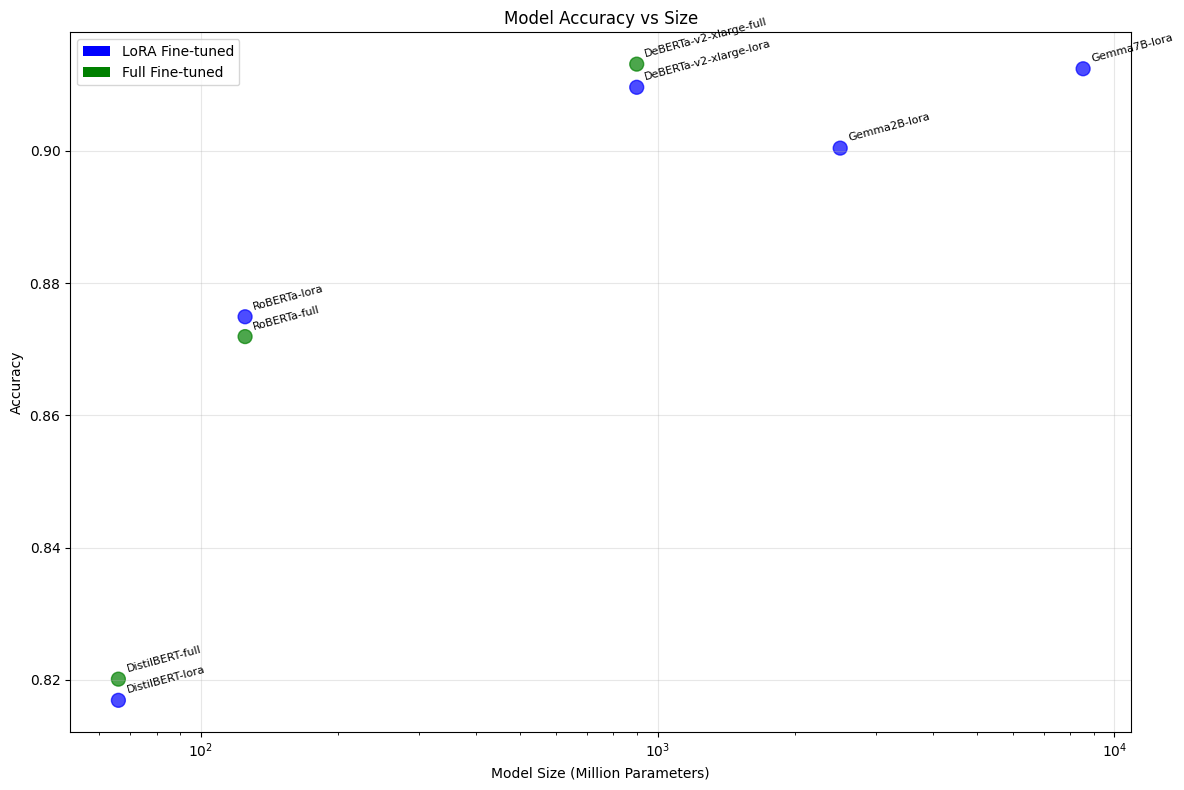

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Model names, their accuracies, and sizes (in millions of parameters)
model_data = {
    "DistilBERT-lora": {"accuracy": 0.8169, "size": 66},
    "DistilBERT-full": {"accuracy": 0.8201, "size": 66},
    "RoBERTa-lora": {"accuracy": 0.8749, "size": 125},
    "RoBERTa-full": {"accuracy": 0.8719, "size": 125},
    "DeBERTa-v2-xlarge-lora": {"accuracy": 0.9096, "size": 900},
    "DeBERTa-v2-xlarge-full": {"accuracy": 0.9131, "size": 900},
    "Gemma2B-lora": {"accuracy": 0.9004, "size": 2510},
    "Gemma7B-lora": {"accuracy": 0.9124, "size": 8540},
}

# Extract data for scatter plot
model_names = list(model_data.keys())
accuracies = [model_data[name]["accuracy"] for name in model_names]
sizes = [model_data[name]["size"] for name in model_names]

# Create scatter plot
plt.figure(figsize=(12, 8))

# Color code by model type
colors = []
for name in model_names:
    if "prompt" in name:
        colors.append('red')
    elif "lora" in name:
        colors.append('blue')
    else:
        colors.append('green')

plt.scatter(sizes, accuracies, c=colors, alpha=0.7, s=100)

# Add labels for each point
for i, name in enumerate(model_names):
    plt.annotate(name, (sizes[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, rotation=15)

plt.xlabel('Model Size (Million Parameters)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Size')
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
                   Patch(facecolor='blue', label='LoRA Fine-tuned'),
                   Patch(facecolor='green', label='Full Fine-tuned')]
plt.legend(handles=legend_elements)

plt.xscale('log')  # Log scale for better visualization of size differences
plt.tight_layout()
plt.show()


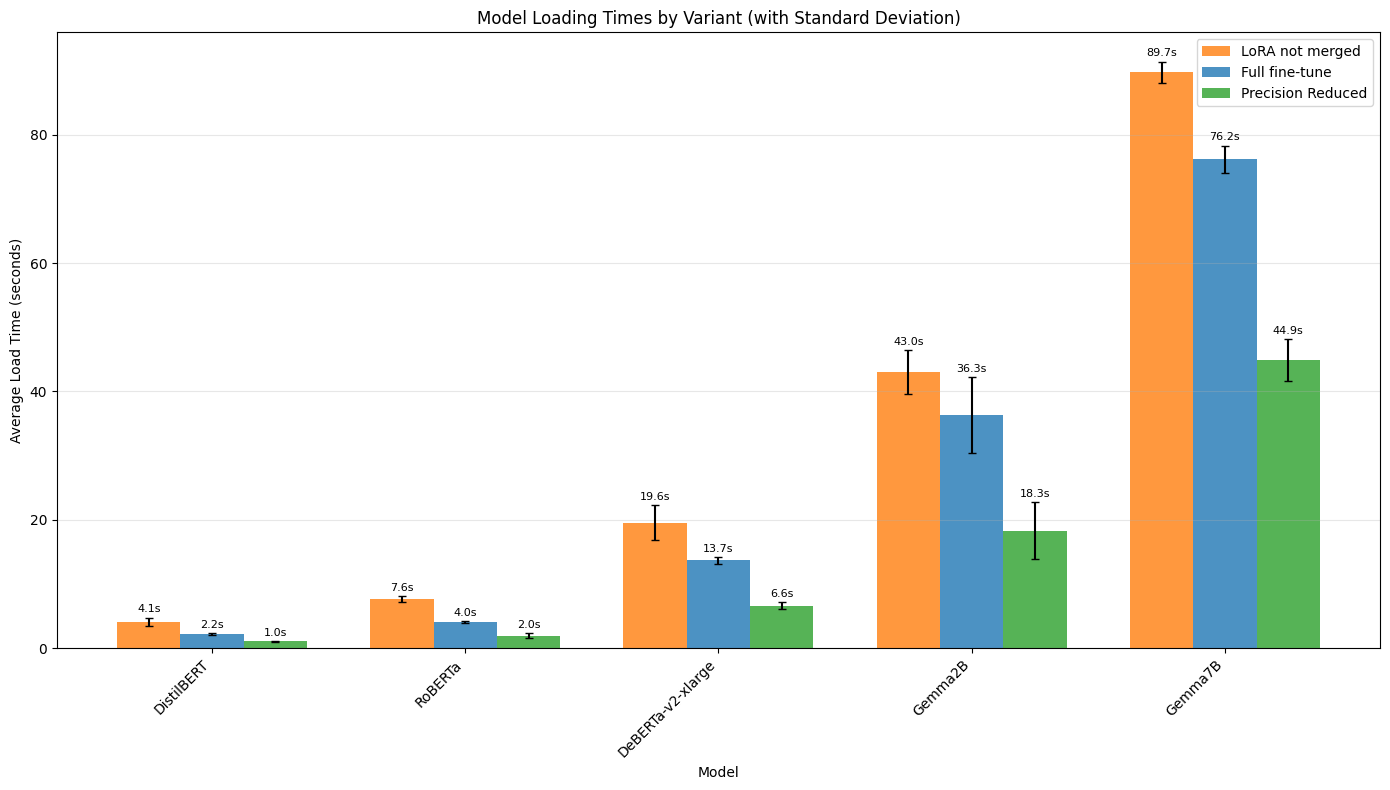


Summary Statistics:

DistilBERT:
  DistilBERT-full-false: 2.185s ± 0.168s
  DistilBERT-lora-false: 4.130s ± 0.629s
  DistilBERT-lora-true: 1.036s ± 0.041s

RoBERTa:
  RoBERTa-full-false: 4.033s ± 0.136s
  RoBERTa-lora-false: 7.635s ± 0.424s
  RoBERTa-lora-true: 1.961s ± 0.437s

DeBERTa_v2_xlarge:
  DeBERTa_v2_xlarge-full-false: 13.686s ± 0.530s
  DeBERTa_v2_xlarge-lora-false: 19.558s ± 2.672s
  DeBERTa_v2_xlarge-lora-true: 6.628s ± 0.554s

Gemma2B:
  Gemma2B-full-false: 36.298s ± 5.892s
  Gemma2B-lora-false: 43.012s ± 3.417s
  Gemma2B-lora-true: 18.293s ± 4.435s

Gemma7B:
  Gemma7B-full-false: 76.166s ± 2.141s
  Gemma7B-lora-false: 89.750s ± 1.631s
  Gemma7B-lora-true: 44.915s ± 3.227s


In [105]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Load the benchmark results
with open('merged_model_loads.json', 'r') as f:
    load_time_data = json.load(f)

# Group data by model name
model_groups = defaultdict(list)
for entry in load_time_data:
    run_name = entry['run_name']
    # Extract base model name (everything before first hyphen)
    base_name = run_name.split('-')[0]
    model_groups[base_name].append(entry)

# Define model order by size
model_order = ['DistilBERT', 'RoBERTa', 'DeBERTa_v2_xlarge', 'Gemma2B', 'Gemma7B']

# Filter and order model names based on available data
model_names = [name for name in model_order if name in model_groups]

# For plotting, replace DeBERTa_v2_xlarge with DeBERTa-v2-xlarge in labels
plot_labels = [name if name != 'DeBERTa_v2_xlarge' else 'DeBERTa-v2-xlarge' for name in model_names]

# Prepare data for plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors and patterns for different variants
variant_colors = {
    'lora-false': '#ff7f0e',  # orange
    'full-false': '#1f77b4',  # blue
    'lora-true': '#2ca02c'    # green
}

variant_labels = {
    'lora-false': 'LoRA not merged',
    'full-false': 'Full fine-tune',
    'lora-true': 'Precision Reduced'
}

# Calculate positions for grouped bars
n_models = len(model_names)
bar_width = 0.25
x_positions = np.arange(n_models)

# Plot bars for each variant
for variant_idx, (variant_type, color) in enumerate(variant_colors.items()):
    avg_times = []
    std_devs = []
    
    for model_name in model_names:
        # Find entry matching this variant
        matching_entry = None
        for entry in model_groups[model_name]:
            run_name = entry['run_name']
            if variant_type in run_name:
                matching_entry = entry
                break
        
        if matching_entry:
            avg_times.append(matching_entry['avg_time'])
            # Calculate standard deviation from individual times
            times = matching_entry['times']
            std_devs.append(np.std(times))
        else:
            avg_times.append(0)
            std_devs.append(0)
    
    # Plot bars with error bars
    bars = ax.bar(x_positions + variant_idx * bar_width, avg_times, 
                  bar_width, label=variant_labels[variant_type], color=color, alpha=0.8,
                  yerr=std_devs, capsize=3)
    
    # Add value labels on bars
    for i, (bar, avg_time) in enumerate(zip(bars, avg_times)):
        if avg_time > 0:  # Only show label if there's a value
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + std_devs[i] + 0.5,
                   f'{avg_time:.1f}s', ha='center', va='bottom', fontsize=8)

# Customize the plot
ax.set_xlabel('Model')
ax.set_ylabel('Average Load Time (seconds)')
ax.set_title('Model Loading Times by Variant (with Standard Deviation)')
ax.set_xticks(x_positions + bar_width)
ax.set_xticklabels(plot_labels, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for model_name in model_names:
    print(f"\n{model_name}:")
    for entry in model_groups[model_name]:
        run_name = entry['run_name']
        avg_time = entry['avg_time']
        times = entry['times']
        std_dev = np.std(times)
        print(f"  {run_name}: {avg_time:.3f}s ± {std_dev:.3f}s")


../latency/distilbert_full.json
../latency/distilbert_lora.json
../latency/roberta_full.json
../latency/roberta_lora.json
../latency/deberta_full.json
../latency/deberta_lora.json
../latency/gemma2b_lora.json
../latency/gemma7b_lora.json


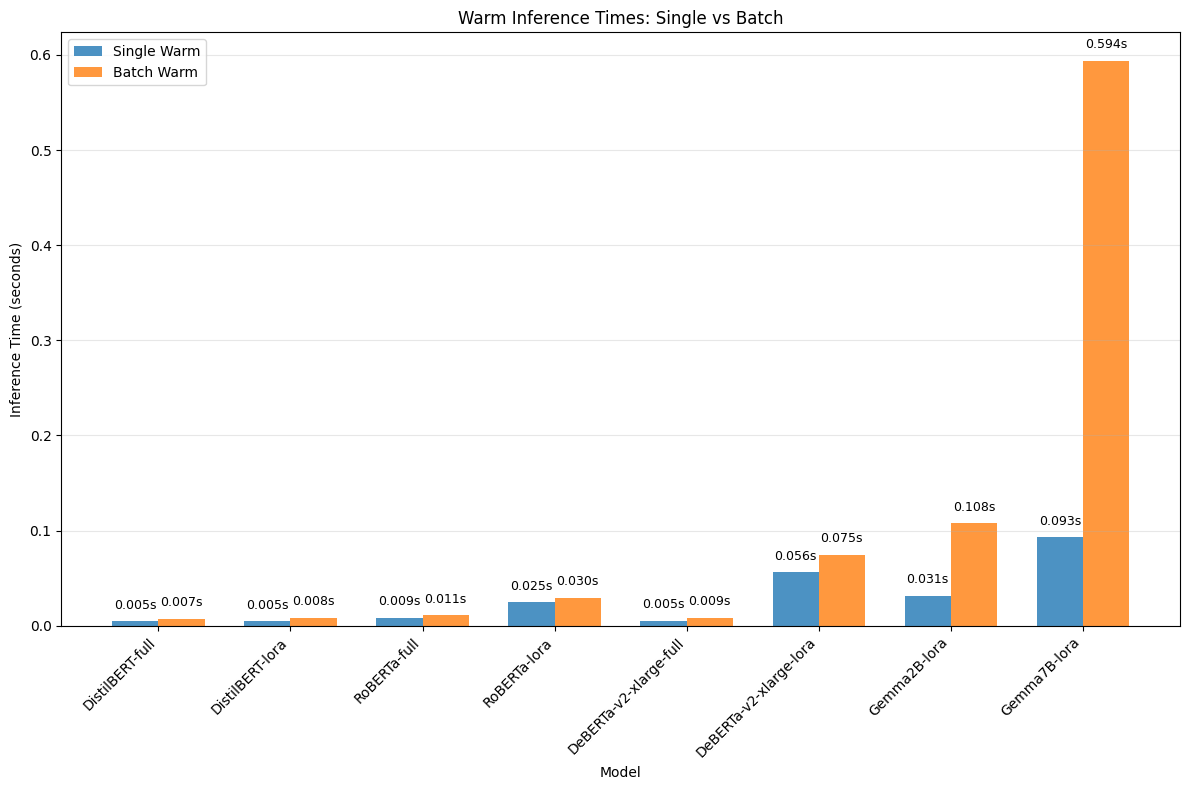

In [101]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the latency files to process
latency_files = [
    'distilbert_full.json',
    'distilbert_lora.json',
    'roberta_full.json',
    'roberta_lora.json',
    'deberta_full.json',
    'deberta_lora.json', 
    'gemma2b_lora.json',
    'gemma7b_lora.json'
]

# # Define the GPT model files to process
# gpt_files = [
#     'gpt-4o_prompt.json',
#     'gpt-5_prompt.json'
# ]

# Collect inference times for original models
models = []
single_warm_times = []
batch_warm_times = []

for filename in latency_files:
    filepath = os.path.join('../latency', filename)
    if os.path.exists(filepath):
        print(filepath)
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Extract model name from filename
        model_name = filename.replace('.json', '').replace('_', ' ').title().replace(' Lora', '-lora').replace('bert', "BERT").replace(" Full", "-full").replace("DeBERTa", "DeBERTa-v2-xlarge")
        models.append(model_name)
        
        # Get warm single inference time (single_50_avg)
        single_warm = data.get('single_50_avg', {}).get('inference_time', 0)
        single_warm_times.append(single_warm)
        
        # Get warm batch inference time (batch100_50_avg)
        batch_warm = data.get('batch100_50_avg', {}).get('inference_time', 0)
        batch_warm_times.append(batch_warm / 7)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

x_positions = np.arange(len(models))
bar_width = 0.35

# Plot bars
bars1 = ax.bar(x_positions - bar_width/2, single_warm_times, bar_width, 
               label='Single Warm', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x_positions + bar_width/2, batch_warm_times, bar_width,
               label='Batch Warm', color='#ff7f0e', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}s', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_xlabel('Model')
ax.set_ylabel('Inference Time (seconds)')
ax.set_title('Warm Inference Times: Single vs Batch')
ax.set_xticks(x_positions)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


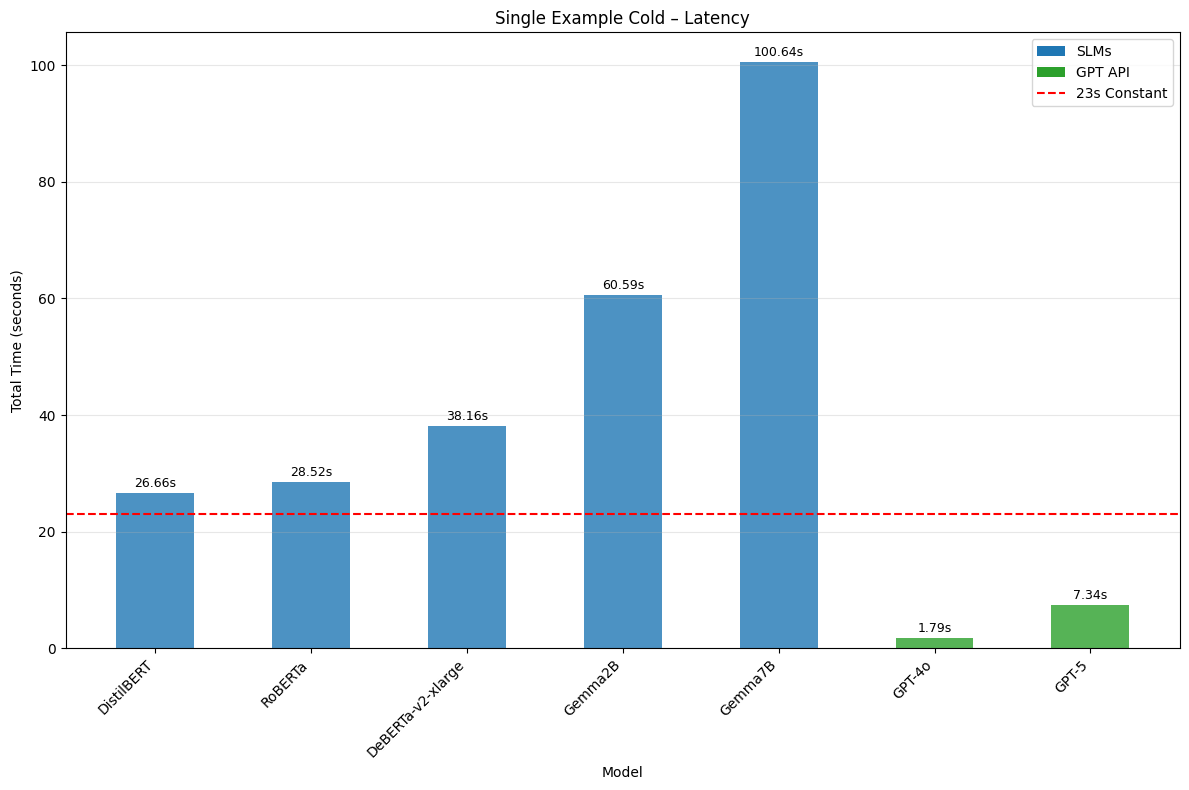

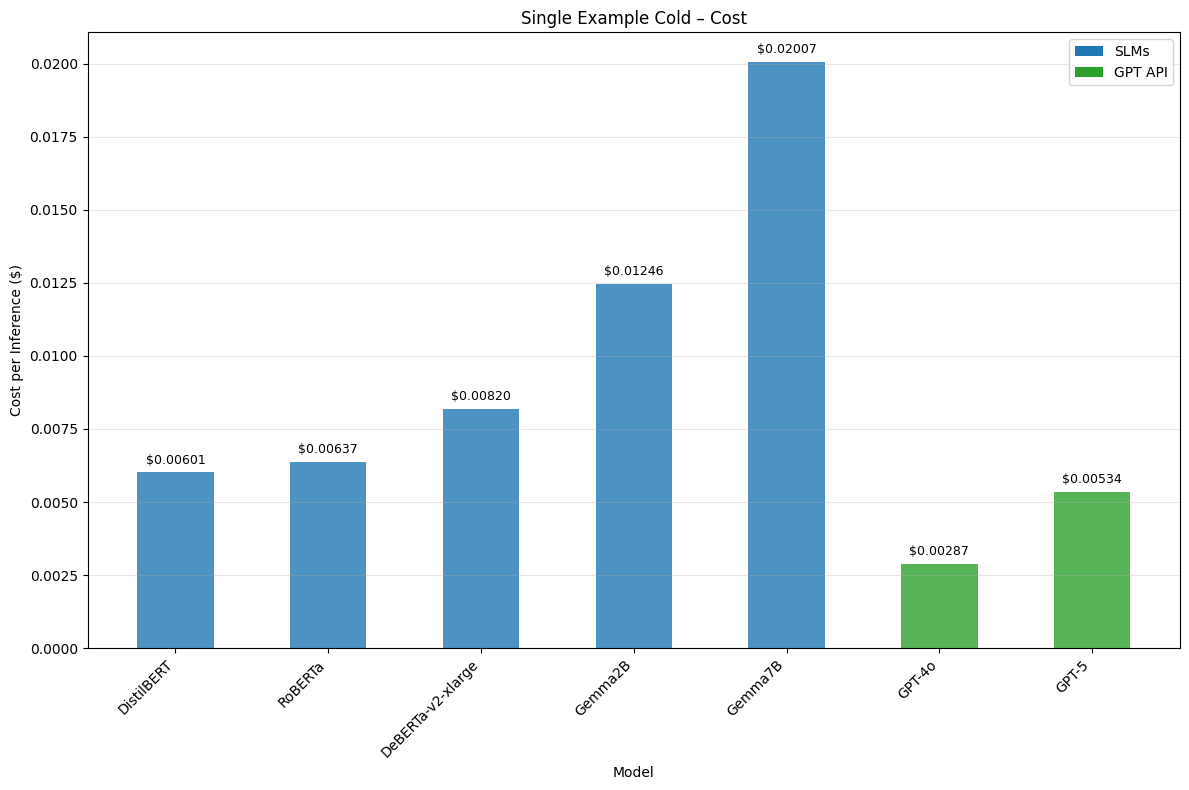

In [107]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

MACHINE_LAUNCH = 23

# Latency files and mapping to merged_model_loads.json run_name
latency_files = [
    ('distilbert_full.json', 'DistilBERT-full-false'),
    ('roberta_full.json', 'RoBERTa-full-false'),
    ('deberta_full.json', 'DeBERTa_v2_xlarge-full-false'),
    ('gemma2b_lora.json', 'Gemma2B-full-false'),
    ('gemma7b_lora.json', 'Gemma7B-full-false')
]

# Load merged_model_loads.json
with open('../experiments/merged_model_loads.json', 'r') as f:
    merged_loads = json.load(f)

# Build a mapping from run_name to avg_time (model load time)
runname_to_loadtime = {}
for entry in merged_loads:
    run_name = entry.get('run_name')
    avg_time = entry.get('avg_time', 0)
    runname_to_loadtime[run_name] = avg_time

models = []
single_cold_times = []

for filename, run_name in latency_files:
    filepath = os.path.join('../latency', filename)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
        # Model name for display
        model_name = filename.replace('.json', '').replace('_', ' ').title().replace(' Lora', '').replace('bert', "BERT").replace(" Full", "").replace("DeBERTa", "DeBERTa-v2-xlarge")
        models.append(model_name)
        # Get warm single inference time (single_50_avg)
        single_warm = data.get('single_50_avg', {}).get('total_time', 0)
        # Get model load time from merged_model_loads.json
        model_load_time = runname_to_loadtime.get(run_name, 0)
        # Add 23s constant
        total_cold = single_warm + model_load_time + MACHINE_LAUNCH
        single_cold_times.append(total_cold)

# Add GPT-4o and GPT-5 bars
gpt_models = []
gpt_cold_times = []
gpt_costs = []

# GPT-4o
gpt4o_path = '../latency/gpt-4o_prompt.json'
if os.path.exists(gpt4o_path):
    with open(gpt4o_path, 'r') as f:
        gpt4o_data = json.load(f)
    gpt4o_time = gpt4o_data.get('single_1000_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-4o')
    gpt_cold_times.append(gpt4o_time)
    # Calculate cost for GPT-4o using the file's pricing and token fields
    single_1000 = gpt4o_data.get('single_1000_avg', {})
    prices = gpt4o_data.get('prices', {})
    total_input = single_1000.get('avg_input_tokens', 0) * 1000
    total_cached_input = single_1000.get('avg_cached_input_tokens', 0) * 1000
    total_output = single_1000.get('avg_output_tokens', 0) * 1000
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    # Cost per run = (input + cached_input + output) * price per 1M / 1_000_000
    cost_per_run = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    ) / 1000  # Per single example
    gpt_costs.append(cost_per_run)

# GPT-5
gpt5_path = '../latency/gpt-5_prompt.json'
if os.path.exists(gpt5_path):
    with open(gpt5_path, 'r') as f:
        gpt5_data = json.load(f)
    gpt5_time = gpt5_data.get('single_1000_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-5')
    gpt_cold_times.append(gpt5_time)
    # Calculate cost for GPT-5 using the file's pricing and token fields
    single_1000 = gpt5_data.get('single_1000_avg', {})
    prices = gpt5_data.get('prices', {})
    total_input = single_1000.get('avg_input_tokens', 0) * 1000
    total_cached_input = single_1000.get('avg_cached_input_tokens', 0) * 1000
    total_output = single_1000.get('avg_output_tokens', 0) * 1000
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    cost_per_run = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    ) / 1000  # Per single example
    gpt_costs.append(cost_per_run)

# Combine all models and times
all_models = models + gpt_models
all_cold_times = single_cold_times + gpt_cold_times

# Plot latency chart
fig, ax = plt.subplots(figsize=(12, 8))
x_positions = np.arange(len(all_models))
bar_width = 0.5

# Color: blue for local, green for GPT
colors = ['#1f77b4'] * len(models) + ['#2ca02c'] * len(gpt_models)

bars = ax.bar(x_positions, all_cold_times, bar_width, color=colors, alpha=0.8, label='Single Example Cold Total Time')

# Add value labels (only total time)
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        label = f"{height:.2f}s"
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                label, ha='center', va='bottom', fontsize=9)

# Add horizontal line at 23s (only for local models)
line_handle = None
if len(models) > 0:
    line_handle = ax.axhline(23, color='red', linestyle='--', linewidth=1.5, label='23s Constant')

ax.set_xlabel('Model')
ax.set_ylabel('Total Time (seconds)')
ax.set_title('Single Example Cold – Latency')
ax.set_xticks(x_positions)
ax.set_xticklabels(all_models, rotation=45, ha='right')

# Custom legend: use Patch for bars, Line2D for line
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_handles = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API')
]
if line_handle is not None:
    legend_handles.append(Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='23s Constant'))
ax.legend(handles=legend_handles)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- COST CHART ---

# For local models: cost = (time + 5) * 0.00019
local_costs = [(t + 5) * 0.00019 for t in single_cold_times]
# For GPT: already calculated in gpt_costs above
all_costs = local_costs + gpt_costs

# Plot cost chart
fig2, ax2 = plt.subplots(figsize=(12, 8))
bars2 = ax2.bar(x_positions, all_costs, bar_width, color=colors, alpha=0.8, label='Single Example Cold Cost')

# Add value labels (cost)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    if height > 0:
        label = f"${height:.5f}"
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(all_costs)*0.01,
                 label, ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Model')
ax2.set_ylabel('Cost per Inference ($)')
ax2.set_title('Single Example Cold – Cost')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Custom legend: add 23s constant to legend for cost chart as well
legend_handles2 = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API'),
]
ax2.legend(handles=legend_handles2)
plt.tight_layout()
plt.show()


Total 1000 cold for DistilBERT: 2.185068 + 23 + 1000 * 1.47
Total 1000 cold for RoBERTa: 4.032523 + 23 + 1000 * 1.492
Total 1000 cold for DeBERTa-v2-xlarge: 13.686466 + 23 + 1000 * 1.471
Total 1000 cold for Gemma2B: 36.29803 + 23 + 1000 * 1.288
Total 1000 cold for Gemma7B: 76.165919 + 23 + 1000 * 1.47


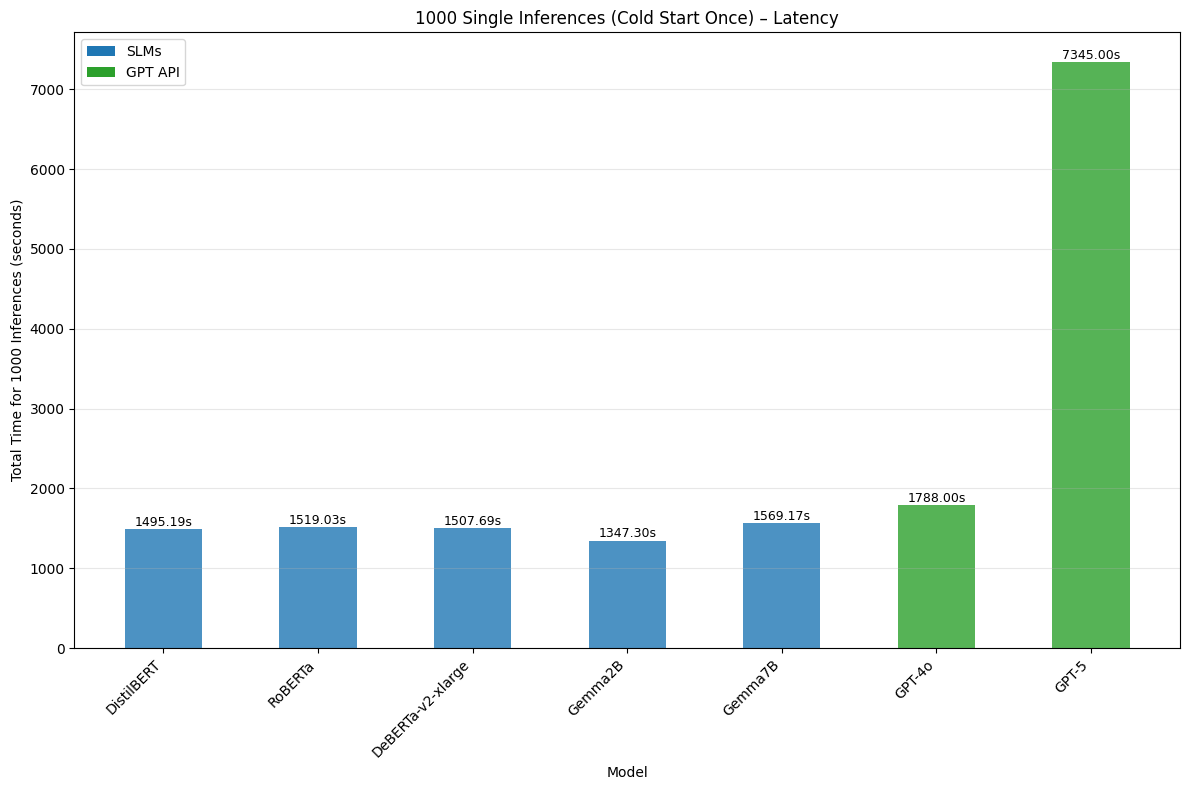

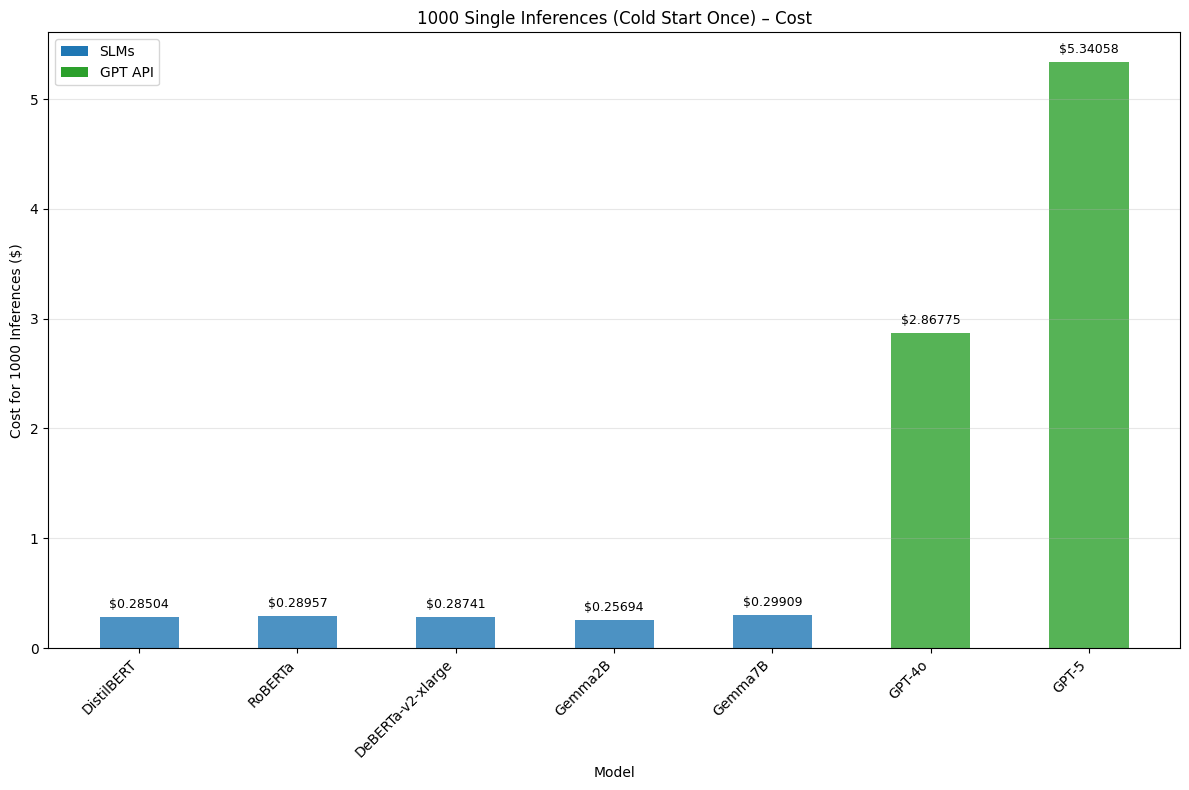

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

MACHINE_LAUNCH = 23
N = 1000  # Number of single inferences

# Latency files and mapping to merged_model_loads.json run_name
latency_files = [
    ('distilbert_full.json', 'DistilBERT-full-false'),
    ('roberta_full.json', 'RoBERTa-full-false'),
    ('deberta_full.json', 'DeBERTa_v2_xlarge-full-false'),
    ('gemma2b_lora.json', 'Gemma2B-full-false'),
    ('gemma7b_lora.json', 'Gemma7B-full-false')
]

# Load merged_model_loads.json
with open('../experiments/merged_model_loads.json', 'r') as f:
    merged_loads = json.load(f)

# Build a mapping from run_name to avg_time (model load time)
runname_to_loadtime = {}
for entry in merged_loads:
    run_name = entry.get('run_name')
    avg_time = entry.get('avg_time', 0)
    runname_to_loadtime[run_name] = avg_time

models = []
cold_1000_times = []

for filename, run_name in latency_files:
    filepath = os.path.join('../latency', filename)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
        # Model name for display
        model_name = filename.replace('.json', '').replace('_', ' ').title().replace(' Lora', '').replace('bert', "BERT").replace(" Full", "").replace("DeBERTa", "DeBERTa-v2-xlarge")
        models.append(model_name)
        # Get warm single inference time (single_50_avg)
        single_warm = data.get('single_50_avg', {}).get('total_time', 0)
        
        # Get model load time from merged_model_loads.json
        model_load_time = runname_to_loadtime.get(run_name, 0)
        # Add 23s constant
        # For 1000 inferences: cold start (model_load_time + 23) once, plus 1000 * single_warm
        print(f"Total 1000 cold for {model_name}: {model_load_time} + {MACHINE_LAUNCH} + {N} * {single_warm}")
        total_cold_1000 = model_load_time + MACHINE_LAUNCH + N * single_warm
        cold_1000_times.append(total_cold_1000)

# Add GPT-4o and GPT-5 bars
gpt_models = []
gpt_1000_times = []
gpt_1000_costs = []

# GPT-4o
gpt4o_path = '../latency/gpt-4o_prompt.json'
if os.path.exists(gpt4o_path):
    with open(gpt4o_path, 'r') as f:
        gpt4o_data = json.load(f)
    gpt4o_time = gpt4o_data.get('single_1000_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-4o')
    gpt_1000_times.append(gpt4o_time * N)
    # Calculate cost for GPT-4o using the file's pricing and token fields
    single_1000 = gpt4o_data.get('single_1000_avg', {})
    prices = gpt4o_data.get('prices', {})
    total_input = single_1000.get('avg_input_tokens', 0) * N
    total_cached_input = single_1000.get('avg_cached_input_tokens', 0) * N
    total_output = single_1000.get('avg_output_tokens', 0) * N
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    # Cost for 1000 runs = (input + cached_input + output) * price per 1M / 1_000_000
    cost_1000 = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    )
    gpt_1000_costs.append(cost_1000)

# GPT-5
gpt5_path = '../latency/gpt-5_prompt.json'
if os.path.exists(gpt5_path):
    with open(gpt5_path, 'r') as f:
        gpt5_data = json.load(f)
    gpt5_time = gpt5_data.get('single_1000_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-5')
    gpt_1000_times.append(gpt5_time * N)
    # Calculate cost for GPT-5 using the file's pricing and token fields
    single_1000 = gpt5_data.get('single_1000_avg', {})
    prices = gpt5_data.get('prices', {})
    total_input = single_1000.get('avg_input_tokens', 0) * N
    total_cached_input = single_1000.get('avg_cached_input_tokens', 0) * N
    total_output = single_1000.get('avg_output_tokens', 0) * N
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    cost_1000 = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    )
    gpt_1000_costs.append(cost_1000)

# Combine all models and times
all_models = models + gpt_models
all_1000_times = cold_1000_times + gpt_1000_times

# Plot latency chart
fig, ax = plt.subplots(figsize=(12, 8))
x_positions = np.arange(len(all_models))
bar_width = 0.5

# Color: blue for local, green for GPT
colors = ['#1f77b4'] * len(models) + ['#2ca02c'] * len(gpt_models)

bars = ax.bar(x_positions, all_1000_times, bar_width, color=colors, alpha=0.8, label='1000 Single Inferences (Cold Start Once)')

# Add value labels (only total time)
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        label = f"{height:.2f}s"
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                label, ha='center', va='bottom', fontsize=9)

# Add horizontal line at 23s (only for local models, but not meaningful for 1000 runs, so skip)

ax.set_xlabel('Model')
ax.set_ylabel('Total Time for 1000 Inferences (seconds)')
ax.set_title('1000 Single Inferences (Cold Start Once) – Latency')
ax.set_xticks(x_positions)
ax.set_xticklabels(all_models, rotation=45, ha='right')

# Custom legend: use Patch for bars
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API')
]
ax.legend(handles=legend_handles)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- COST CHART ---

# For local models: cost = (model_load_time + 23 + 1000 * single_warm + 5) * 0.00019
# (add +5s for "other overhead" once)
local_costs = [(t + 5) * 0.00019 for t in cold_1000_times]
# For GPT: already calculated in gpt_1000_costs above
all_costs = local_costs + gpt_1000_costs

# Plot cost chart
fig2, ax2 = plt.subplots(figsize=(12, 8))
bars2 = ax2.bar(x_positions, all_costs, bar_width, color=colors, alpha=0.8, label='1000 Single Inferences (Cold Start Once) Cost')

# Add value labels (cost)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    if height > 0:
        label = f"${height:.5f}"
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(all_costs)*0.01,
                 label, ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Model')
ax2.set_ylabel('Cost for 1000 Inferences ($)')
ax2.set_title('1000 Single Inferences (Cold Start Once) – Cost')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Custom legend
legend_handles2 = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API'),
]
ax2.legend(handles=legend_handles2)
plt.tight_layout()
plt.show()


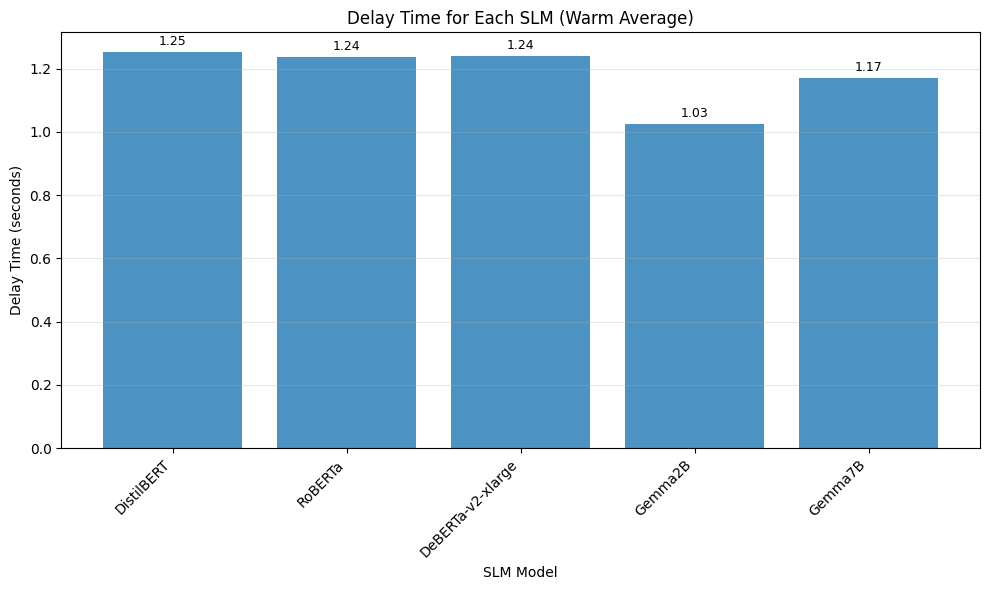

In [159]:
# Plot only delay_time for each SLM
delay_times = []
slm_names = []

for filename, run_name in latency_files:
    filepath = os.path.join('../latency', filename)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
        model_name = filename.replace('.json', '').replace('_', ' ').title().replace(' Lora', '').replace('bert', "BERT").replace(" Full", "").replace("DeBERTa", "DeBERTa-v2-xlarge")
        slm_names.append(model_name)
        delay_time = data.get('single_50_avg', {}).get('delay_time', 0)
        delay_times.append(delay_time)

fig3, ax3 = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(slm_names))
bars3 = ax3.bar(x_pos, delay_times, color='#1f77b4', alpha=0.8)

# Print values above bars
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + max(delay_times)*0.01,
             f"{height:.2f}", ha='center', va='bottom', fontsize=9)

ax3.set_xlabel('SLM Model')
ax3.set_ylabel('Delay Time (seconds)')
ax3.set_title('Delay Time for Each SLM (Warm Average)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(slm_names, rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


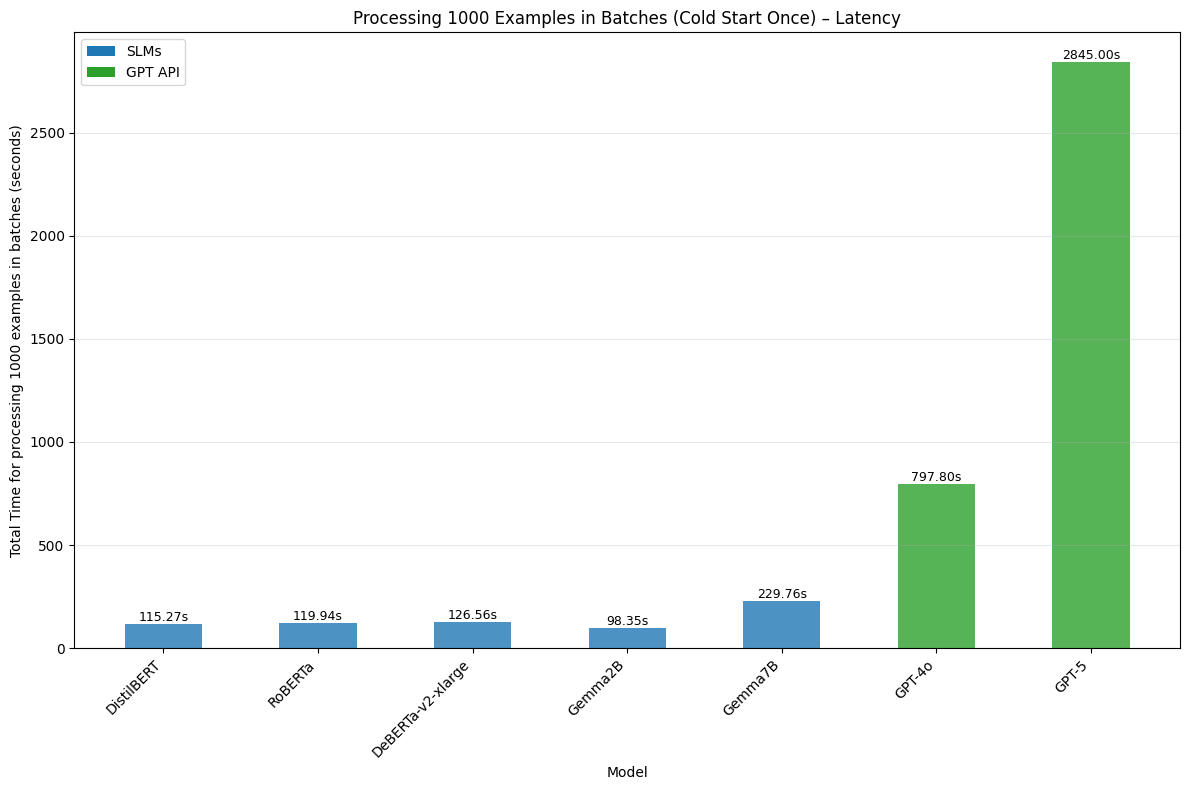

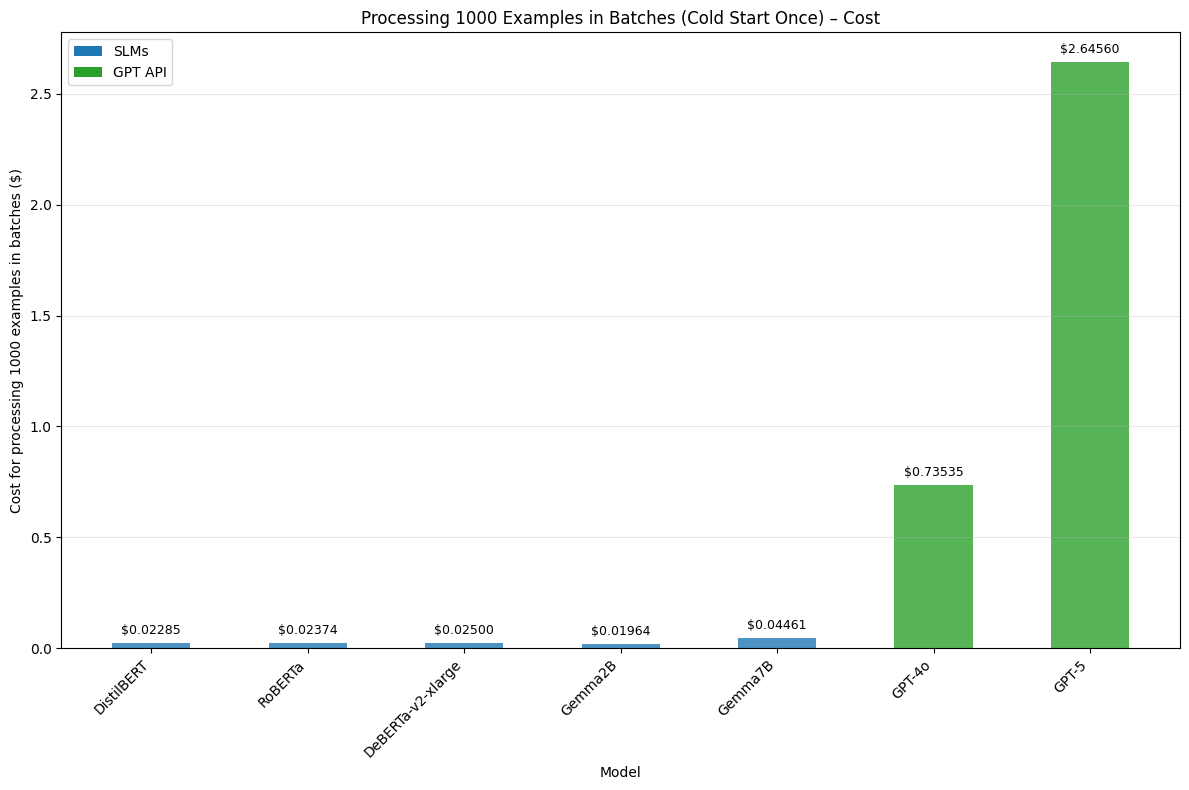

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

MACHINE_LAUNCH = 23
N = 10  # Number of inferences

# Latency files and mapping to merged_model_loads.json run_name
latency_files = [
    ('distilbert_full.json', 'DistilBERT-full-false'),
    ('roberta_full.json', 'RoBERTa-full-false'),
    ('deberta_full.json', 'DeBERTa_v2_xlarge-full-false'),
    ('gemma2b_lora.json', 'Gemma2B-full-false'),
    ('gemma7b_lora.json', 'Gemma7B-full-false')
]

# Load merged_model_loads.json
with open('../experiments/merged_model_loads.json', 'r') as f:
    merged_loads = json.load(f)

# Build a mapping from run_name to avg_time (model load time)
runname_to_loadtime = {}
for entry in merged_loads:
    run_name = entry.get('run_name')
    avg_time = entry.get('avg_time', 0)
    runname_to_loadtime[run_name] = avg_time

models = []
cold_1000_times = []
for filename, run_name in latency_files:
    filepath = os.path.join('../latency', filename)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
        # Model name for display
        model_name = filename.replace('.json', '').replace('_', ' ').title().replace(' Lora', '').replace('bert', "BERT").replace(" Full", "").replace("DeBERTa", "DeBERTa-v2-xlarge")
        models.append(model_name)
        # Get warm single inference time (single_50_avg)
        model_load_time = runname_to_loadtime.get(run_name, 0)

        batch_warm = data.get('batch100_50_avg', {})
        delay_time = batch_warm['delay_time']
        execution_time = batch_warm['execution_time']
        inference_time = batch_warm['inference_time']
        total_time = batch_warm['total_time']
        network_latency = total_time - delay_time - execution_time
        singel_batch_inference_time = inference_time / 7
        single_batch_execution_time = execution_time - (6 * singel_batch_inference_time)
        single_batch_total_time = delay_time + single_batch_execution_time + network_latency

        new_total_cold_100 = model_load_time + MACHINE_LAUNCH + 63 * single_batch_total_time
        cold_1000_times.append(new_total_cold_100)
# Add GPT-4o and GPT-5 bars
gpt_models = []
gpt_1000_times = []
gpt_1000_costs = []

# GPT-4o
gpt4o_path = '../latency/gpt-4o_prompt.json'
if os.path.exists(gpt4o_path):
    with open(gpt4o_path, 'r') as f:
        gpt4o_data = json.load(f)
    gpt4o_time = gpt4o_data.get('batch10_100_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-4o')
    gpt_1000_times.append(gpt4o_time * 100)
    # Calculate cost for GPT-4o using the file's pricing and token fields
    batch10_100_avg = gpt4o_data.get('batch10_100_avg', {})
    prices = gpt4o_data.get('prices', {})
    total_input = batch10_100_avg.get('avg_input_tokens', 0) * 100
    total_cached_input = batch10_100_avg.get('avg_cached_input_tokens', 0) * 100
    total_output = batch10_100_avg.get('avg_output_tokens', 0) * 100
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    # Cost for 1000 runs = (input + cached_input + output) * price per 1M / 1_000_000
    cost_1000 = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    )
    gpt_1000_costs.append(cost_1000)

# GPT-5
gpt5_path = '../latency/gpt-5_prompt.json'
if os.path.exists(gpt5_path):
    with open(gpt5_path, 'r') as f:
        gpt5_data = json.load(f)
    gpt5_time = gpt5_data.get('batch10_100_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-5')
    gpt_1000_times.append(gpt5_time * 100)
    # Calculate cost for GPT-5 using the file's pricing and token fields
    batch10_100_avg = gpt5_data.get('batch10_100_avg', {})
    prices = gpt5_data.get('prices', {})
    total_input = batch10_100_avg.get('avg_input_tokens', 0) * 100
    total_cached_input = batch10_100_avg.get('avg_cached_input_tokens', 0) * 100
    total_output = batch10_100_avg.get('avg_output_tokens', 0) * 100
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    cost_1000 = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    )
    gpt_1000_costs.append(cost_1000)

# Combine all models and times
all_models = models + gpt_models
all_1000_times = cold_1000_times + gpt_1000_times

# Plot latency chart
fig, ax = plt.subplots(figsize=(12, 8))
x_positions = np.arange(len(all_models))
bar_width = 0.5

# Color: blue for local, green for GPT
colors = ['#1f77b4'] * len(models) + ['#2ca02c'] * len(gpt_models)

bars = ax.bar(x_positions, all_1000_times, bar_width, color=colors, alpha=0.8, label='Processing 1000 Examples in Batches (Cold Start Once)')

# Add value labels (only total time)
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        label = f"{height:.2f}s"
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                label, ha='center', va='bottom', fontsize=9)

# Add horizontal line at 23s (only for local models, but not meaningful for 1000 runs, so skip)

ax.set_xlabel('Model')
ax.set_ylabel('Total Time for processing 1000 examples in batches (seconds)')
ax.set_title('Processing 1000 Examples in Batches (Cold Start Once) – Latency')
ax.set_xticks(x_positions)
ax.set_xticklabels(all_models, rotation=45, ha='right')

# Custom legend: use Patch for bars
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API')
]
ax.legend(handles=legend_handles)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- COST CHART ---

# For local models: cost = (model_load_time + 23 + 1000 * single_warm + 5) * 0.00019
# (add +5s for "other overhead" once)
local_costs = [(t + 5) * 0.00019 for t in cold_1000_times]
# For GPT: already calculated in gpt_1000_costs above
all_costs = local_costs + gpt_1000_costs

# Plot cost chart
fig2, ax2 = plt.subplots(figsize=(12, 8))
bars2 = ax2.bar(x_positions, all_costs, bar_width, color=colors, alpha=0.8, label='Processing 1000 Examples in Batches (Cold Start Once)')

# Add value labels (cost)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    if height > 0:
        label = f"${height:.5f}"
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(all_costs)*0.01,
                 label, ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Model')
ax2.set_ylabel('Cost for processing 1000 examples in batches ($)')
ax2.set_title('Processing 1000 Examples in Batches (Cold Start Once) – Cost')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Custom legend
legend_handles2 = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API'),
]
ax2.legend(handles=legend_handles2)
plt.tight_layout()
plt.show()


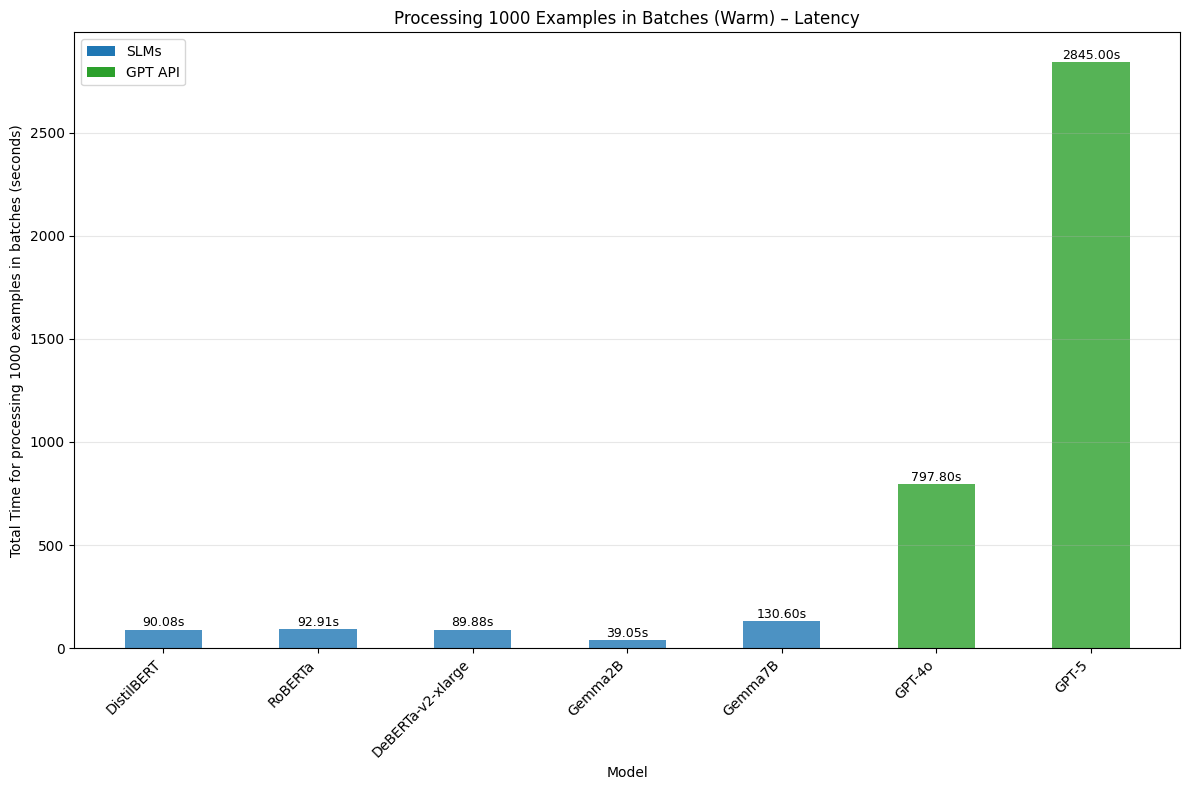

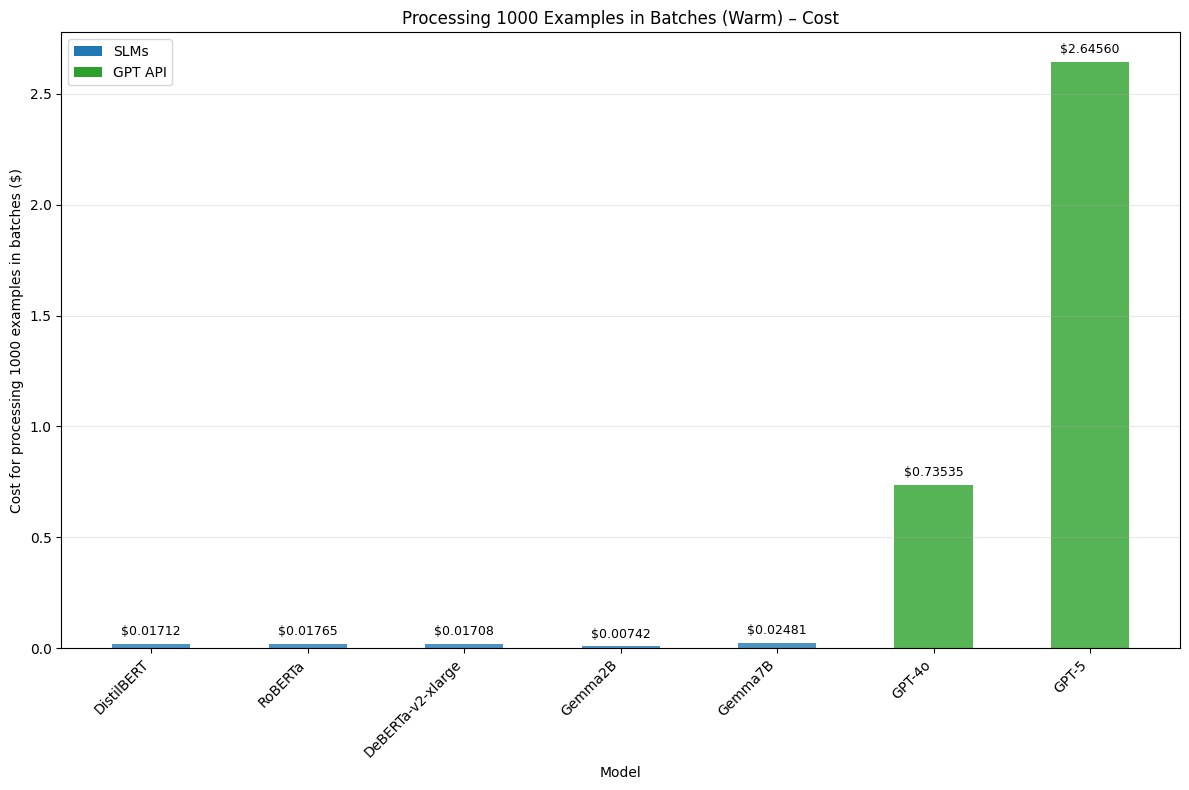

In [149]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

MACHINE_LAUNCH = 23
N = 10  # Number of inferences

# Latency files and mapping to merged_model_loads.json run_name
latency_files = [
    ('distilbert_full.json', 'DistilBERT-full-false'),
    ('roberta_full.json', 'RoBERTa-full-false'),
    ('deberta_full.json', 'DeBERTa_v2_xlarge-full-false'),
    ('gemma2b_lora.json', 'Gemma2B-full-false'),
    ('gemma7b_lora.json', 'Gemma7B-full-false')
]

# Load merged_model_loads.json
with open('../experiments/merged_model_loads.json', 'r') as f:
    merged_loads = json.load(f)

# Build a mapping from run_name to avg_time (model load time)
runname_to_loadtime = {}
for entry in merged_loads:
    run_name = entry.get('run_name')
    avg_time = entry.get('avg_time', 0)
    runname_to_loadtime[run_name] = avg_time

models = []
cold_1000_times = []

for filename, run_name in latency_files:
    filepath = os.path.join('../latency', filename)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
        # Model name for display
        model_name = filename.replace('.json', '').replace('_', ' ').title().replace(' Lora', '').replace('bert', "BERT").replace(" Full", "").replace("DeBERTa", "DeBERTa-v2-xlarge")
        models.append(model_name)
        # Get warm single inference time (single_50_avg)
        model_load_time = runname_to_loadtime.get(run_name, 0)

        batch_warm = data.get('batch100_50_avg', {})
        delay_time = batch_warm['delay_time']
        execution_time = batch_warm['execution_time']
        inference_time = batch_warm['inference_time']
        total_time = batch_warm['total_time']
        network_latency = total_time - delay_time - execution_time
        singel_batch_inference_time = inference_time / 7
        single_batch_execution_time = execution_time - (6 * singel_batch_inference_time)
        single_batch_total_time = delay_time + single_batch_execution_time + network_latency

        new_total_cold_100 = 63 * single_batch_total_time
        cold_1000_times.append(new_total_cold_100)

# Add GPT-4o and GPT-5 bars
gpt_models = []
gpt_1000_times = []
gpt_1000_costs = []

# GPT-4o
gpt4o_path = '../latency/gpt-4o_prompt.json'
if os.path.exists(gpt4o_path):
    with open(gpt4o_path, 'r') as f:
        gpt4o_data = json.load(f)
    gpt4o_time = gpt4o_data.get('batch10_100_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-4o')
    gpt_1000_times.append(gpt4o_time * 100)
    # Calculate cost for GPT-4o using the file's pricing and token fields
    batch10_100_avg = gpt4o_data.get('batch10_100_avg', {})
    prices = gpt4o_data.get('prices', {})
    total_input = batch10_100_avg.get('avg_input_tokens', 0) * 100
    total_cached_input = batch10_100_avg.get('avg_cached_input_tokens', 0) * 100
    total_output = batch10_100_avg.get('avg_output_tokens', 0) * 100
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    # Cost for 1000 runs = (input + cached_input + output) * price per 1M / 1_000_000
    cost_1000 = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    )
    gpt_1000_costs.append(cost_1000)

# GPT-5
gpt5_path = '../latency/gpt-5_prompt.json'
if os.path.exists(gpt5_path):
    with open(gpt5_path, 'r') as f:
        gpt5_data = json.load(f)
    gpt5_time = gpt5_data.get('batch10_100_avg', {}).get('avg_total_time', 0)
    gpt_models.append('GPT-5')
    gpt_1000_times.append(gpt5_time * 100)
    # Calculate cost for GPT-5 using the file's pricing and token fields
    batch10_100_avg = gpt5_data.get('batch10_100_avg', {})
    prices = gpt5_data.get('prices', {})
    total_input = batch10_100_avg.get('avg_input_tokens', 0) * 100
    total_cached_input = batch10_100_avg.get('avg_cached_input_tokens', 0) * 100
    total_output = batch10_100_avg.get('avg_output_tokens', 0) * 100
    price_in = prices.get('1mln_input', 0)
    price_cached = prices.get('1mln_cached_input', 0)
    price_out = prices.get('1mln_output', 0)
    cost_1000 = (
        (total_input * price_in + total_cached_input * price_cached + total_output * price_out) / 1_000_000
    )
    gpt_1000_costs.append(cost_1000)

# Combine all models and times
all_models = models + gpt_models
all_1000_times = cold_1000_times + gpt_1000_times

# Plot latency chart
fig, ax = plt.subplots(figsize=(12, 8))
x_positions = np.arange(len(all_models))
bar_width = 0.5

# Color: blue for local, green for GPT
colors = ['#1f77b4'] * len(models) + ['#2ca02c'] * len(gpt_models)

bars = ax.bar(x_positions, all_1000_times, bar_width, color=colors, alpha=0.8, label='Processing 1000 Examples in Batches (Warm)')

# Add value labels (only total time)
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        label = f"{height:.2f}s"
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                label, ha='center', va='bottom', fontsize=9)

# Add horizontal line at 23s (only for local models, but not meaningful for 1000 runs, so skip)

ax.set_xlabel('Model')
ax.set_ylabel('Total Time for processing 1000 examples in batches (seconds)')
ax.set_title('Processing 1000 Examples in Batches (Warm) – Latency')
ax.set_xticks(x_positions)
ax.set_xticklabels(all_models, rotation=45, ha='right')

# Custom legend: use Patch for bars
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API')
]
ax.legend(handles=legend_handles)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- COST CHART ---

# For local models: cost = (model_load_time + 23 + 1000 * single_warm + 5) * 0.00019
# (add +5s for "other overhead" once)
local_costs = [(t) * 0.00019 for t in cold_1000_times]
# For GPT: already calculated in gpt_1000_costs above
all_costs = local_costs + gpt_1000_costs

# Plot cost chart
fig2, ax2 = plt.subplots(figsize=(12, 8))
bars2 = ax2.bar(x_positions, all_costs, bar_width, color=colors, alpha=0.8, label='Processing 1000 Examples in Batches (Warm)')

# Add value labels (cost)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    if height > 0:
        label = f"${height:.5f}"
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(all_costs)*0.01,
                 label, ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Model')
ax2.set_ylabel('Cost for processing 1000 examples in batches ($)')
ax2.set_title('Processing 1000 Examples in Batches (Warm) – Cost')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Custom legend
legend_handles2 = [
    Patch(facecolor='#1f77b4', label='SLMs'),
    Patch(facecolor='#2ca02c', label='GPT API'),
]
ax2.legend(handles=legend_handles2)
plt.tight_layout()
plt.show()


In [150]:
# (1569 - 229) / 1569
# 0.15 * 1569
98.35-23-36


39.349999999999994

In [ ]:
for filename, run_name in latency_files:
    filepath = os.path.join('../latency', filename)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
        # Model name for display
        model_name = filename.replace('.json', '').replace('_', ' ').title().replace(' Lora', '').replace('bert', "BERT").replace(" Full", "").replace("DeBERTa", "DeBERTa-v2-xlarge")
        models.append(model_name)
        # Get warm single inference time (single_50_avg)
        model_load_time = runname_to_loadtime.get(run_name, 0)

        batch_warm = data.get('batch100_50_avg', {})
        delay_time = batch_warm['delay_time']
        execution_time = batch_warm['execution_time']
        inference_time = batch_warm['inference_time']
        total_time = batch_warm['total_time']
        network_latency = total_time - delay_time - execution_time
        singel_batch_inference_time = inference_time / 7
        single_batch_execution_time = execution_time - (6 * singel_batch_inference_time)
        single_batch_total_time = delay_time + single_batch_execution_time + network_latency

        new_total_cold_100 = model_load_time + MACHINE_LAUNCH + 63 * single_batch_total_time
        cold_1000_times.append(new_total_cold_100)

1.474 1.4299085714285713
39.925068 115.269308
1.541 1.4747171428571428
42.442523 119.939703
1.478 1.426597142857143
51.466466 126.562086
1.266 0.6198
71.95803 98.34543
5.637 2.072999999999999
155.535919 229.76491899999994


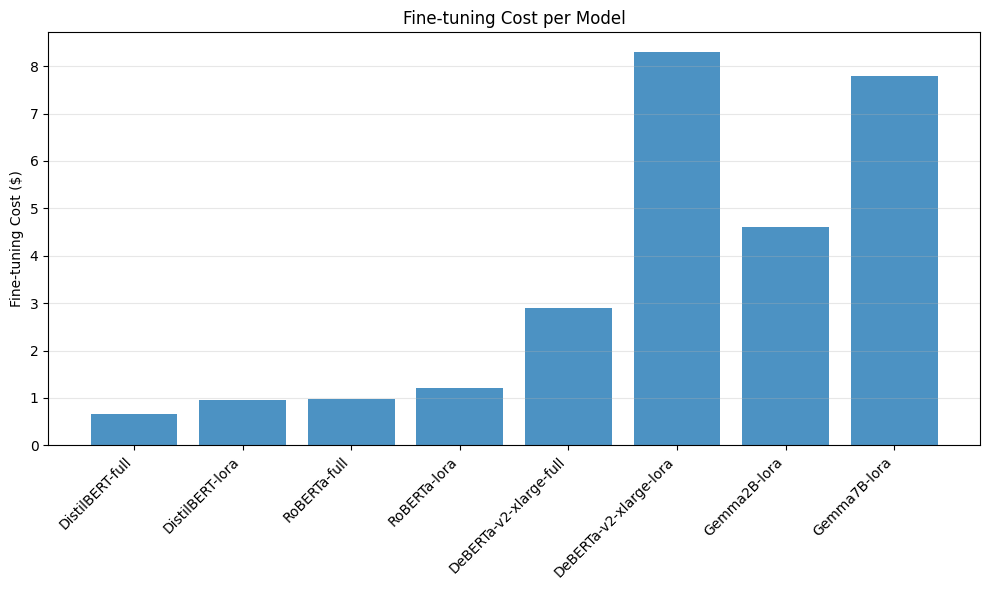

In [ ]:
import json
import matplotlib.pyplot as plt

# Define your desired order here
model_order = [
    "DistilBERT-full",
    "DistilBERT-lora",
    "RoBERTa-full",
    "RoBERTa-lora",
    "DeBERTa-v2-xlarge-full",
    "DeBERTa-v2-xlarge-lora",
    "Gemma2B-lora",
    "Gemma7B-lora"
]

with open('./costs.json', 'r') as f:
    costs = json.load(f)

model_names = []
training_costs = []

for model in model_order:
    details = costs.get(model, {})
    train = details.get('training', {})
    try:
        gpu_cost_hr = float(train.get('gpu_cost_hr_$', 0))
        total_time_hr = float(train.get('total_time_hr', 0))
        cost = total_time_hr #* gpu_cost_hr
        model_names.append(model)
        training_costs.append(cost)
    except Exception:
        continue

plt.figure(figsize=(10,6))
plt.bar(model_names, training_costs, color='#1f77b4', alpha=0.8)
plt.ylabel('Fine-tuning Time (hours)')
plt.title('Fine-tuning Time per Model')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

